# Emily Tseng (et397)

## 1) Logistic Regression (multinomial)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets, neighbors, linear_model


In [2]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [4]:
assert len(digits.data) == 1797
assert len(digits.data[0]) == 64

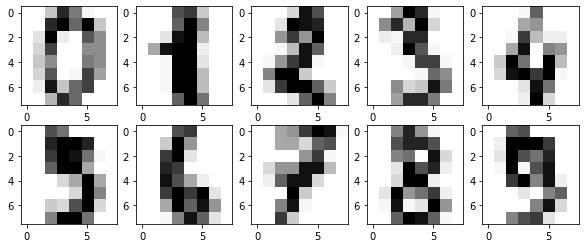

In [5]:
# First 10 samples
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(digits.data[i].reshape(8,8),cmap='Greys',aspect='auto',interpolation='none')

**1.** First train the default logistic regression `logreg_ovr` as in the digits.ipynb notebook (using same training and test set). Check that you get the same .938888 = 169/180 score, meaning that it gets 11 of the 180 test images incorrect.  What are the indices of the `X_test array` corresponding to the ones that it gets wrong?

In [6]:
n_samples = len(X_digits)
#use first 90% as training set
f = int(.9 * n_samples)
print ('90% = first', f, 'samples of', n_samples)

X_train = X_digits[:f] #first 90%
y_train = y_digits[:f]

X_test = X_digits[f:]  #last 10%
y_test = y_digits[f:]

90% = first 1617 samples of 1797


In [7]:
logreg_ovr = linear_model.LogisticRegression(max_iter=10000).fit(X_train, y_train)
print('LogisticRegression test score (ovr): {:.6f}'.format(logreg_ovr.score(X_test, y_test)))
print('Incorrect indices')

LogisticRegression test score (ovr): 0.938889


In [10]:
yhats = logreg_ovr.predict(X_test)
wrong_indices = [i for i, val in enumerate(yhats != y_test) if val]
assert len(wrong_indices) == 11
wrong_indices

[11, 41, 43, 71, 73, 109, 110, 112, 113, 130, 148]

**2.** Consider the three images `test3 = [np.copy(X_test[i]) for i in (109, 110, 113)]`. Check that those are ones that the classifier gets wrong. See if you can manipulate a single pixel of the three images to get the classifier to get them right, as follows. Each is supposed to be a 3, so one way to do this would be to look at the weights associated to classifying an object as a 3. `logref_ovr.coef_` is an array of shape `(10,64)`, and each row is an array of 64 weights that multiply the corresponding pixel values. (These weights are called $\vec w_i$ in the [lec5.pdf](https://www.cs.cornell.edu/~ginsparg/6010/spr20/lec5.pdf) notes.) `logref_ovr.intercept_` is an array of `10` numbers that provide the thresholds for each of the 10 "one versus rest" classifiers (0 or not 0, 1 or not 1, ...), and are added in turn to the corresponding sum of products of weights and features for each digit. (These are called $b_i$ in the formula $x_i = \vec w_i \cdot \vec f + \vec b_i$ in the lec5 notes.) Thus `logreg_ovr.coef_[3]` gives the 64 weights used in the "3 or not 3" classifier.  Identify the largest weight and see if the corresponding pixel in the three images is already large (the max value is 16). If it is not already large, then see what happens when you increase its value. Otherwise look for the most negative weight, and see if that corresponding pixel in the three images has a large value, and see what happens if you decrease it. Either way should make it more likely for the image to be classified as a 3.

Note that `logreg_ovr.predict(test3)` will give the predictions for each of the three, `y_test[[109, 110, 113]]` will give their labelled values, and `logreg_ovr.predict_proba(test3)` will give the ten probabilities that they're each of the ten digits. (The `.predict()` method picks the label with the highest probability.)

In [55]:
test_samples = []
for i in (109, 110, 113):
    assert i in wrong_indices
    test_samples.append((i, np.copy(X_test[i])))

In [93]:
max_pixel = int(np.argmax(logreg_ovr.coef_[3]))

for i, sample in test_samples:
    probs = logreg_ovr.predict_proba(sample.reshape(1,-1))[0]
    prediction = logreg_ovr.predict(sample.reshape(1,-1))[0]
    print('Sample index {}\nBEFORE:\tValue at pix{}={}\tPrediction={}\tProb 3={}'.format(i, max_pixel, X_test[i][max_pixel], prediction, probs[2]))
    new_sample = np.copy(sample)
    new_sample[max_pixel] += 20
    new_prediction = logreg_ovr.predict(new_sample.reshape(1,-1))[0]
    new_probs = logreg_ovr.predict_proba(new_sample.reshape(1,-1))[0]
    print('AFTER:\tValue at pix{}={}\tPrediction={}\tProb 3={}\n'.format(max_pixel, new_sample[max_pixel], new_prediction, new_probs[2]))


Sample index 109
BEFORE:	Value at pix58=5.0	Prediction=8	Prob 3=2.0359380173696113e-06
AFTER:	Value at pix58=25.0	Prediction=3	Prob 3=1.6762879250657413e-06

Sample index 110
BEFORE:	Value at pix58=5.0	Prediction=8	Prob 3=0.14573220267998432
AFTER:	Value at pix58=25.0	Prediction=3	Prob 3=0.1934783802725434

Sample index 113
BEFORE:	Value at pix58=10.0	Prediction=8	Prob 3=1.1312972828688471e-08
AFTER:	Value at pix58=30.0	Prediction=3	Prob 3=1.0649640762454063e-09



**3.** Now let's check how those probabilities are calculated. `logreg_ovr.predict_proba([X_test[0]])` gives the probabilities that the first test image is each of the ten digits (the highest is for 5, which gives correctly the labelled value `y_test[0]` for this image). Use `logreg_ovr.coef_` and `logreg_ovr.intercept_` to calculate the values $x_i = \vec w_i \cdot \vec f + \vec b_i$ (where the 64 $\vec f$ values are given by `X_test[0]`), then plug them into the (binomial) logistic function $q(i) = 1/(1+\exp(-x_i))$. Finally, calculate the probabilities $p(i) = q(i) / \sum_{j=0}^9 q(j)$. These should agree with the values given by `logreg_ovr.predict_proba([X_test[0]])`.

In [78]:
sample = X_test[0]
x = np.matmul(logreg_ovr.coef_, sample) + logreg_ovr.intercept_
logistic = 1/(1+np.exp(-x))
probs = logistic / np.sum(logistic)
assert not (probs != logreg_ovr.predict_proba(sample.reshape(1,-1)))[0].all()

**4.** Now train a classifier using the 'multinomial' option, 

    logreg_multi = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
    
use it to fit the same training data as above, and score on the same test data. You should find again 169/180, but check whether it misses a different set of 11 images. (In fact, although it misses overall the same number, the ones that it misses are slightly different.)  In particular see whether it misses the three `test3` in part **2**, and see whether the single pixel manipulation used there causes it to get this classifier correct as well.

In [80]:
logreg_multi = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train, y_train)
print('Multinomial LogisticRegression test score: {:.6f}'.format(logreg_multi.score(X_test, y_test)))


Multinomial LogisticRegression test score: 0.938889


In [97]:
yhats = logreg_multi.predict(X_test)
multi_wrong_indices = [i for i, val in enumerate(yhats != y_test) if val]
assert len(multi_wrong_indices) == 11
print('test elements in one but not the other: ', set(multi_wrong_indices).difference(set(wrong_indices)))

test elements in one but not the other:  {106, 63}


In [98]:
max_pixel = int(np.argmax(logreg_multi.coef_[3]))

for i, sample in test_samples:
    prediction = logreg_multi.predict(sample.reshape(1,-1))[0]
    if prediction == y_test[i]:
        print('Sample index {} classified correctly'.format(i))
    else:
        print('Sample index {} wrong'.format(i))
        probs = logreg_multi.predict_proba(sample.reshape(1,-1))[0]
        print('Sample index {}\nBEFORE:\tValue at pix{}={}\tPrediction={}\tProb 3={}'.format(i, max_pixel, X_test[i][max_pixel], prediction, probs[2]))
        new_sample = np.copy(sample)
        new_sample[max_pixel] += 20
        new_prediction = logreg_multi.predict(new_sample.reshape(1,-1))[0]
        new_probs = logreg_multi.predict_proba(new_sample.reshape(1,-1))[0]
        print('AFTER:\tValue at pix{}={}\tPrediction={}\tProb 3={}\n'.format(max_pixel, new_sample[max_pixel], new_prediction, new_probs[2]))

# The same manipulation used for the _ovr classifier -- namely, increasing the max pixel by 20 points -- doesn't work here.


Sample index 109 wrong
Sample index 109
BEFORE:	Value at pix4=16.0	Prediction=8	Prob 3=1.847447668628674e-05
AFTER:	Value at pix4=36.0	Prediction=8	Prob 3=1.239833684956655e-06

Sample index 110 wrong
Sample index 110
BEFORE:	Value at pix4=16.0	Prediction=8	Prob 3=0.18298047518607807
AFTER:	Value at pix4=36.0	Prediction=8	Prob 3=0.023053879568446407

Sample index 113 wrong
Sample index 113
BEFORE:	Value at pix4=16.0	Prediction=8	Prob 3=6.969734338766592e-06
AFTER:	Value at pix4=36.0	Prediction=3	Prob 3=2.6820444460680504e-07



**5.** Finally, see how the `logreg_multi.predict_proba()` probabilities are calculated. Using the `.coef_` and `.intercept_` attributes, calculate the $x_i = \vec w_i \cdot \vec f + \vec b_i$, as in part **3** for $\vec f$ features given by `X_test[0]`. Now calculate the probabilities using the multinomial logistic formula $p(i) = \exp(x_i) / \sum_{i=0}^9 \exp(x_i)$.
These should agree with the values given by `logreg_multi.predict_proba([X_test[0]])`.

In [107]:
sample = X_test[0]
x = np.matmul(logreg_multi.coef_, sample) + logreg_multi.intercept_
exp_x = np.exp(x)
probs = exp_x / np.sum(exp_x)
generated_probs = logreg_multi.predict_proba(sample.reshape(1,-1))
print(probs)
print(generated_probs[0])

[1.56555465e-08 1.10379876e-04 7.79921401e-15 2.94765089e-05
 1.55518715e-05 9.99654021e-01 1.01013771e-05 1.46025435e-09
 1.63153528e-04 1.72987890e-05]
[1.56555465e-08 1.10379876e-04 7.79921401e-15 2.94765089e-05
 1.55518715e-05 9.99654021e-01 1.01013771e-05 1.46025435e-09
 1.63153528e-04 1.72987890e-05]


## 2) Sentiment Analysis II

**A.** Return to problem 3 of [Ex2](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/Ex2.ipynb), and use instead logistic regression for the binary features (again probably easiest to use sklearn.linear_model.LogisticRegression()) on the same feature sets as in parts A,B.

This should be very simple, since the feature sets are the same as before, it's just a question of swapping in [sklearn.linear_model.LogisticRegression()[(https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) instead of [sklearn.naive_bayes.BernoulliNB()](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html) (and you have access to [Ex2 solutions](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/Ex2s.ipynb).

In [108]:
import os
import re
from collections import defaultdict

In [109]:
def get_top1000(dirname):
    #  Generate vocab of 1000 words occurring in the most documents
    if dirname[-1] != '/':
        dirname += '/'
    pos_dir = dirname + 'txt_sentoken/pos/'
    neg_dir = dirname + 'txt_sentoken/neg/'
    doc_freq_counts = defaultdict(set)
    for pos_filename in os.listdir(pos_dir):
        with open(pos_dir + pos_filename, mode="r") as f:
            for line in f:
                toks = re.findall("[a-z0-9']+", line.lower())
                for tok in toks:
                    doc_freq_counts[tok].add('pos_' + pos_filename)
    for neg_filename in os.listdir(neg_dir):
        with open(neg_dir + neg_filename, mode="r") as f:
            for line in f:
                toks = re.findall("[a-z0-9']+", line.lower())
                for tok in toks:
                    doc_freq_counts[tok].add('neg_' + neg_filename)
    top1000withcounts = sorted(doc_freq_counts.items(), key=lambda tup: len(tup[1]), reverse=True)[:1000]
    top1000words = [x[0] for x in top1000withcounts]
    assert len(top1000words) == 1000 == len(top1000withcounts)
    return top1000withcounts, top1000words


In [110]:
vocab_counter, vocab = get_top1000('./review_polarity/')

In [111]:
def get_data(dirname, vocab):
    """
        Reads in dirname for review_polarity and generates:
            X_data per spec: a 2000x1000 matrix representing each of the 1000 neg and 1000 pos reviews as a vector of binary 
            features (presence/absence) for the 1000 words that occur in the largest number of the 2000 documents.
            y_data: 2000x1 array of pos/neg sentiment for each document, 1 for pos and 0 for neg
    """
    X_data = np.zeros((2000,1000))
    y_data = np.zeros((2000,))
    doc_idx = 0
    
    if dirname[-1] != '/':
        dirname += '/'

    neg_dir = dirname + 'txt_sentoken/neg/'
    for neg_filename in os.listdir(neg_dir):
        with open(neg_dir + neg_filename, mode="r") as f:
            for line in f:
                toks = re.findall("[a-z0-9']+", line.lower())
                for tok in toks:
                    if tok in vocab:
                        X_data[doc_idx][vocab.index(tok)] = 1
        doc_idx += 1
    try:
        assert doc_idx == 1000
    except:
        print(doc_idx)
        raise
    
    pos_dir = dirname + 'txt_sentoken/pos/'
    for pos_filename in os.listdir(pos_dir):
        with open(pos_dir + pos_filename, mode="r") as f:
            for line in f:
                toks = re.findall("[a-z0-9']+", line.lower())
                for tok in toks:
                    if tok in vocab:
                        X_data[doc_idx][vocab.index(tok)] = 1
        y_data[doc_idx] = 1
        doc_idx += 1
    try:
        assert doc_idx == 2000
    except:
        print(doc_idx)
        raise

    return X_data, y_data



In [112]:
X_data, y_data = get_data('./review_polarity/', vocab)

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### 3A

In [114]:
logreg = LogisticRegression()
yhats = logreg.fit(X_train, y_train).predict(X_test)
mislabeled = (y_test != yhats).sum()
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], mislabeled))
print("Overall acc: {}".format(1-float(mislabeled / X_test.shape[0])))

Number of mislabeled points out of a total 180 points : 11
Overall acc: 0.9388888888888889


In [115]:
scores = cross_val_score(logreg, X_data, y_data, cv=10)
np.mean(scores)

0.7985

### 3B

In [116]:
def get_discriminating_vocab(dirname, alpha):
    if dirname[-1] != '/':
        dirname += '/'
    pos_dir = dirname + 'txt_sentoken/pos/'
    neg_dir = dirname + 'txt_sentoken/neg/'
    doc_freq_counts = defaultdict(lambda: [set(),set()]) #tok: [neg, pos]
    for pos_filename in os.listdir(pos_dir):
        with open(pos_dir + pos_filename, mode="r") as f:
            for line in f:
                toks = re.findall("[a-z0-9']+", line.lower())
                for tok in toks:
                    doc_freq_counts[tok][1].add('pos_' + pos_filename)
    for neg_filename in os.listdir(neg_dir):
        with open(neg_dir + neg_filename, mode="r") as f:
            for line in f:
                toks = re.findall("[a-z0-9']+", line.lower())
                for tok in toks:
                    doc_freq_counts[tok][0].add('neg_' + neg_filename)
    
    # Convert to ratios
    doc_ratios = dict()
    for tok, sets in doc_freq_counts.items():
        pos_count = len(sets[1])
        neg_count = len(sets[0])
        if pos_count + neg_count > 9: #must appear in at least 10 documents
            pos_ratio = float((alpha+neg_count) / (alpha+pos_count))
            neg_ratio = float((alpha+pos_count) / (alpha+neg_count))
            if pos_ratio > neg_ratio: #just take the higher ratio, we want the "most discriminating"
                doc_ratios[tok] = pos_ratio
            else:
                doc_ratios[tok] = neg_ratio
    vocab_counts = sorted(doc_ratios.items(), key=lambda tup: tup[1], reverse=True)[:1000]
    vocab = [x[0] for x in vocab_counts]
    return vocab_counts, vocab

In [117]:
discriminating_vocab_counts, discriminating_vocab = get_discriminating_vocab('./review_polarity/', 0.5)

In [118]:
X, y = get_data('./review_polarity/', discriminating_vocab)
logreg = LogisticRegression()
scores = cross_val_score(logreg, X, y, cv=10)

In [119]:
print(scores)
np.mean(scores)

[0.92  0.83  0.865 0.89  0.89  0.89  0.9   0.875 0.91  0.905]


0.8875

**B.** Try the same for the 12 class dataset used in Ex1 problem 2D
(as covered as well in [lec5_ex.ipynb](https://nbviewer.jupyter.org/url/www.cs.cornell.edu/~ginsparg/6010/spr20/lec5_ex.ipynb)), again swapping in LogisticRegression() for BernoulliNB()

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

from Ex1data import absdata
from collections import Counter, defaultdict
import re

In [128]:
#make a combined total_vocab
classnames = sorted(absdata)

def words(txt):
    return re.findall(r"['\w]+", txt.lower())

vocab = {subj: defaultdict(lambda: .5) for subj in classnames}
for subj in classnames:
  for txt in absdata[subj][:900]:
     for w in set(words(txt)): vocab[subj][w] += 1

total_vocab = Counter()
for subj in classnames:
    total_vocab += Counter(vocab[subj])
len(total_vocab)

37085

In [129]:
# take Nf most common terms as features
# see what happens for 1000, probably won't do as well as full vocab
Nf = 1000
Nfvocab, Nfn = zip(*total_vocab.most_common(Nf))
kvocab = {w:k for k,w in enumerate(Nfvocab)} #assigns each word an index by rank
svocab = set(Nfvocab)

In [130]:
def features(txt):
    f = np.zeros(Nf)
    for w in set(words(txt)) & svocab: f[kvocab[w]] = 1
    return f  #array of zeros and ones for whether or not feature words occur

In [131]:
X_test = []
X_train = []
for subj in classnames:
    X_train += [features(txt) for txt in absdata[subj][:900]]
    X_test += [features(txt) for txt in absdata[subj][900:]]
    
y_train = np.array([[i]*900 for i in range(12)]).flatten()
y_test = np.array([[i]*100 for i in range(12)]).flatten()

In [132]:
clf = LogisticRegression()
clf.fit(X_train, y_train) #fit the training data
clf.score(X_test, y_test)

0.7816666666666666

## 3) Mortality

**A)** To get a feeling for the data, first select out and plot the total death rate data for this demographic, combining male and female.

In [133]:
import pandas as pd 

In [150]:
df = pd.read_csv('./mortality/cdc0.tsv', sep='\t', nrows=801)
white_rows = df[df['Race'] == 'White']
non_hispanic_rows = white_rows[white_rows['Hispanic Origin'] == 'Not Hispanic or Latino']
totals = non_hispanic_rows[non_hispanic_rows['Notes'] == 'Total']
totals

,Notes,Race,Race Code,Year,Year Code,Hispanic Origin,Hispanic Origin Code,Gender,Gender Code,Deaths,Population,Crude Rate
604,Total,White,2106-3,1999.0,1999.0,Not Hispanic or Latino,2186-2,NaN,NaN,106808,27995805,381.5
614,Total,White,2106-3,2000.0,2000.0,Not Hispanic or Latino,2186-2,NaN,NaN,111964,28669184,390.5
624,Total,White,2106-3,2001.0,2001.0,Not Hispanic or Latino,2186-2,NaN,NaN,117086,29733531,393.8
634,Total,White,2106-3,2002.0,2002.0,Not Hispanic or Latino,2186-2,NaN,NaN,119812,29880552,401.0
644,Total,White,2106-3,2003.0,2003.0,Not Hispanic or Latino,2186-2,NaN,NaN,121832,30260532,402.6
654,Total,White,2106-3,2004.0,2004.0,Not Hispanic or Latino,2186-2,NaN,NaN,123037,30629390,401.7
664,Total,White,2106-3,2005.0,2005.0,Not Hispanic or Latino,2186-2,NaN,NaN,126669,31024600,408.3
674,Total,White,2106-3,2006.0,2006.0,Not Hispanic or Latino,2186-2,NaN,NaN,127969,31365190,408.0
684,Total,White,2106-3,2007.0,2007.0,Not Hispanic or Latino,2186-2,NaN,NaN,127898,31561137,405.2
694,Total,White,2106-3,2008.0,2008.0,Not Hispanic or Latino,2186-2,NaN,NaN,130423,31631081,412.3


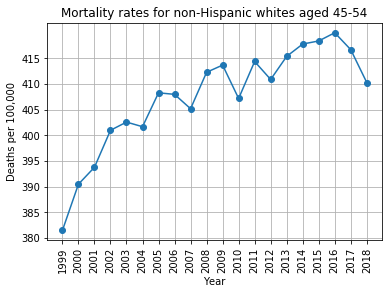

In [180]:
x = totals['Year']
y = [float(i) for i in totals['Crude Rate']]
plt.plot(x, y, 'o-')
plt.xticks(np.arange(min(x), max(x)+1, 1.0), rotation=90)
plt.yticks(np.arange(380, 420, 5.0))
plt.xlabel('Year')
plt.ylabel('Deaths per 100,000')
plt.title('Mortality rates for non-Hispanic whites aged 45-54')
plt.grid()
plt.show()

**B) i)** This next part of the problem is to see whether there's a gender effect. Now partition the data according to the 'M' or 'F' column, and plot the two lines on a single graph.  Because the mean for women averages around 300, and the mean for men around 500, to compare them on the same graph you should rescale the data for the two groups by their 1999 values, so that they both start at 1 and give the fractional change from that start year ("relative death rate"). You should find a significant gender effect.

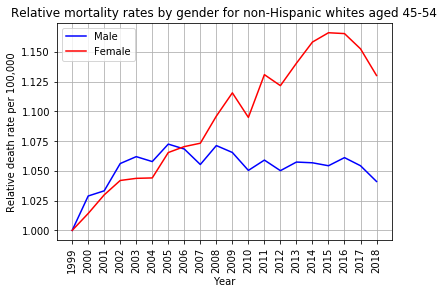

In [193]:
males = non_hispanic_rows[non_hispanic_rows['Gender'] == 'Male']
females = non_hispanic_rows[non_hispanic_rows['Gender'] == 'Female']
male_rates = np.array([float(i) for i in males['Crude Rate']]) / float(males[males['Year'] == 1999]['Crude Rate'])
female_rates = np.array([float(i) for i in females['Crude Rate']]) / float(females[females['Year'] == 1999]['Crude Rate'])

x = totals['Year']
plt.plot(x, male_rates, 'b-', label="Male")
plt.plot(x, female_rates, 'r-', label="Female")
plt.xticks(np.arange(min(x), max(x)+1, 1.0), rotation=90)
# plt.yticks(np.arange(380, 420, 5.0))
plt.xlabel('Year')
plt.ylabel('Relative death rate per 100,000')
plt.title('Relative mortality rates by gender for non-Hispanic whites aged 45-54')
plt.grid()
plt.legend()
plt.show()


&nbsp; **ii)** Use `linregress()` to calculate the slopes of the two plots, and multiply by 19 to get the 'smoothed' rate of overall increase for the 19 year timeframe 1999-2018. (The slope itself gives the increase per year, rather than over the full timeframe.)

In [197]:
print('Male rate of overall mortality increase: {}'.format(linregress(x, male_rates).slope * 19))
print('Female rate of overall mortality increase: {}'.format(linregress(x, female_rates).slope * 19))

Male rate of overall mortality increase: 0.01891963731947196
Female rate of overall mortality increase: 0.16265378749364512


**C)** The third part of this problem is to visualize any geographic effects.

&nbsp; **i)** For each state, calculate the linear fit to the slope of the data (as in B.ii))  for both men and women.
Print out the fifty results for each gender, sorted from most to least increase in mortality rate.

In [206]:
df = pd.read_csv('./mortality/cdc1.tsv', sep='\t', nrows=7525)
white_rows = df[df['Race'] == 'White']
non_hispanic_rows = white_rows[white_rows['Hispanic Origin'] == 'Not Hispanic or Latino']

In [207]:
non_hispanic_rows

,Notes,Race,Race Code,Year,Year Code,Hispanic Origin,Hispanic Origin Code,Gender,Gender Code,State,State Code,Deaths,Population,Crude Rate
3835,NaN,White,2106-3,1999.0,1999.0,Not Hispanic or Latino,2186-2,Female,F,Alabama,1.0,732.0,223053,328.2
3836,NaN,White,2106-3,1999.0,1999.0,Not Hispanic or Latino,2186-2,Female,F,Alaska,2.0,76.0,33648,225.9
3837,NaN,White,2106-3,1999.0,1999.0,Not Hispanic or Latino,2186-2,Female,F,Arizona,4.0,689.0,231796,297.2
3838,NaN,White,2106-3,1999.0,1999.0,Not Hispanic or Latino,2186-2,Female,F,Arkansas,5.0,480.0,145226,330.5
3839,NaN,White,2106-3,1999.0,1999.0,Not Hispanic or Latino,2186-2,Female,F,California,6.0,3728.0,1246174,299.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7504,NaN,White,2106-3,2018.0,2018.0,Not Hispanic or Latino,2186-2,Male,M,Virginia,51.0,1626.0,356835,455.7
7505,NaN,White,2106-3,2018.0,2018.0,Not Hispanic or Latino,2186-2,Male,M,Washington,53.0,1345.0,343477,391.6
7506,NaN,White,2106-3,2018.0,2018.0,Not Hispanic or Latino,2186-2,Male,M,West Virginia,54.0,883.0,110193,801.3
7507,NaN,White,2106-3,2018.0,2018.0,Not Hispanic or Latino,2186-2,Male,M,Wisconsin,55.0,1245.0,315382,394.8


In [229]:
collector = dict()
for state in df['State']:
    if not state:
        break
    state_rows = non_hispanic_rows[non_hispanic_rows['State'] == state]
    males = state_rows[state_rows['Gender'] == 'Male']
    females = state_rows[state_rows['Gender'] == 'Female']
    males = males[males['Crude Rate'] != 'Unreliable']
    females = females[females['Crude Rate'] != 'Unreliable']
    try:
        male_rates = np.array([float(i) for i in males['Crude Rate']]) / float(males[males['Year'] == 1999]['Crude Rate'])
        female_rates = np.array([float(i) for i in females['Crude Rate']]) / float(females[females['Year'] == 1999]['Crude Rate'])
        male_rate_increase = linregress(males['Year'], male_rates).slope * (len(male_rates)-1)
        female_rate_increase = linregress(females['Year'], female_rates).slope * (len(female_rates)-1)
        collector[state] = {
            'Male': male_rate_increase,
            'Female': female_rate_increase
        }
    except:
        print(state)
        print(males)
        print(females)
        raise
        break
collector

nan
Empty DataFrame
Columns: [Notes, Race, Race Code, Year, Year Code, Hispanic Origin, Hispanic Origin Code, Gender, Gender Code, State, State Code, Deaths, Population, Crude Rate]
Index: []
Empty DataFrame
Columns: [Notes, Race, Race Code, Year, Year Code, Hispanic Origin, Hispanic Origin Code, Gender, Gender Code, State, State Code, Deaths, Population, Crude Rate]
Index: []


TypeError: cannot convert the series to <class 'float'>

In [228]:
collector

{'Alaska': {'Male': 0.0954700922685333, 'Female': 0.31131980016442173},
 'Arizona': {'Male': -0.12824781235437277, 'Female': 0.07240434531820816},
 'California': {'Male': -0.178373608857769, 'Female': -0.08553762414056533},
 'Michigan': {'Male': 0.024992378513505293, 'Female': 0.17678252437094877},
 'Minnesota': {'Male': -0.009060955518945653, 'Female': 0.006731096440481896},
 'Montana': {'Male': 0.06448264438473143, 'Female': 0.27713745611666213},
 'New Mexico': {'Male': 0.18406751749691228, 'Female': 0.4988074182626713},
 'North Carolina': {'Male': -0.00979453421105122,
  'Female': 0.23766799854703965},
 'Oklahoma': {'Male': 0.12534546598581836, 'Female': 0.4226381827128096},
 'South Dakota': {'Male': -0.013196368848542736,
  'Female': 0.21262443438914033},
 'Washington': {'Male': -0.04541812719078618, 'Female': 0.09827624187685863},
 'Wisconsin': {'Male': -0.005765293293580962, 'Female': 0.09112600701063896},
 'Colorado': {'Male': -0.04891517977571385, 'Female': 0.0575789131142206},

In [231]:
print('Male increases in relative mortality rate by state, highest to lowest')
sorted(collector.items(), key=lambda tup: tup[1]['Male'], reverse=True)

Male increases in relative mortality rate by state, highest to lowest


[('West Virginia', {'Male': 0.3604044244728655, 'Female': 0.6924008254987389}),
 ('Kentucky', {'Male': 0.3170737768059042, 'Female': 0.5116763545334975}),
 ('Maine', {'Male': 0.24428978815860947, 'Female': 0.21516970424533444}),
 ('New Hampshire',
  {'Male': 0.20992437855645407, 'Female': 0.10400971333807164}),
 ('North Dakota', {'Male': 0.2097522560871786, 'Female': 0.303788701792504}),
 ('Ohio', {'Male': 0.1981591358588164, 'Female': 0.3149675984137731}),
 ('Iowa', {'Male': 0.19812368934181956, 'Female': 0.25005117091084234}),
 ('New Mexico', {'Male': 0.18406751749691228, 'Female': 0.4988074182626713}),
 ('Delaware', {'Male': 0.173977606606845, 'Female': 0.17708094473744557}),
 ('Tennessee', {'Male': 0.16904600975232947, 'Female': 0.4306759407883004}),
 ('Indiana', {'Male': 0.16874085331532135, 'Female': 0.2638780927102097}),
 ('Wyoming', {'Male': 0.15851801829455467, 'Female': 0.22482762143112525}),
 ('Nebraska', {'Male': 0.14938954667847013, 'Female': 0.36826377505989166}),
 ('Alab

In [232]:
print('Female increases in relative mortality rate by state, highest to lowest')
sorted(collector.items(), key=lambda tup: tup[1]['Female'], reverse=True)

Female increases in relative mortality rate by state, highest to lowest


[('West Virginia', {'Male': 0.3604044244728655, 'Female': 0.6924008254987389}),
 ('Mississippi', {'Male': 0.127177919626, 'Female': 0.5705684986531825}),
 ('Kentucky', {'Male': 0.3170737768059042, 'Female': 0.5116763545334975}),
 ('New Mexico', {'Male': 0.18406751749691228, 'Female': 0.4988074182626713}),
 ('Alabama', {'Male': 0.1489500688868831, 'Female': 0.48021241403325504}),
 ('Arkansas', {'Male': 0.13439634996808597, 'Female': 0.4509790360925004}),
 ('Tennessee', {'Male': 0.16904600975232947, 'Female': 0.4306759407883004}),
 ('Oklahoma', {'Male': 0.12534546598581836, 'Female': 0.4226381827128096}),
 ('Nebraska', {'Male': 0.14938954667847013, 'Female': 0.36826377505989166}),
 ('Ohio', {'Male': 0.1981591358588164, 'Female': 0.3149675984137731}),
 ('Alaska', {'Male': 0.0954700922685333, 'Female': 0.31131980016442173}),
 ('North Dakota', {'Male': 0.2097522560871786, 'Female': 0.303788701792504}),
 ('South Carolina',
  {'Male': 0.08438284025138476, 'Female': 0.29793465144342346}),
 ('M

&nbsp; **ii)** For each of men and women (so two separate plots), visualize the geographic data as in  problem 1 above:
for each state plot the slope of the data (multiplied by 18, to get the smoothed increase over the 18 year time frame) using the seismic color map. It might look something like the below (note this isn't intended to be faithful to the data, and instead corresponds to grouping states by the 10 HHS [= Health and Human Services] geographic regions, but regardless you should see geographic effects, though of course the states won't be the same color as their neighbors as in the below):

In [233]:
from mpl_toolkits.basemap import Basemap


ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [ ]:
plt.figure(figsize=(12,6))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
             projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.readshapefile('geodata/st99_d90','states',drawbounds=True) #reads geodata
for polygon,info in zip(m.states,m.states_info):
   if info['NAME'] == 'New York':
        xdata,ydata = zip(*polygon)
        plt.fill(xdata,ydata)

&nbsp; **iii)** You should notice some overall similarities in the geographic plots by state for the M and F data.
What is the Pearson correlation (`from scipy.stats import pearsonr`) between the fifty M and F slopes (i.e., fitted slopes for fifty states for each gender, omit 'District of Columbia')?  Also make a scatter plot of the M vs F smoothed slopes for the fifty states, with a linear fit. It should look something like this: